In [1]:
#dependencies
import json
import pandas as pd
import numpy as np

import re

from sqlalchemy import create_engine
import psycopg2

# will need to set up config.py file in the same folder (db_password = "password")
from config import db_password

import time

from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

#Dependencies for visualization
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

plt.rcParams["figure.figsize"]=(12,8)

# Code for Visualizations

In [2]:
# read in data 
real_fake_df = pd.read_csv('fake_job_postings.csv')
real_fake_df.shape

(17880, 18)

In [3]:
real_fake_df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
# Type of data in each column
real_fake_df.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

In [5]:
# Showing the amount of unique inputs in each column, easiest to focus on the ones with the smallest. "required_education" and "required_experience"
# both had small amounts of unique inputs
real_fake_df.nunique()

job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

In [6]:
real_fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [7]:
# Split location data into Country and State
real_fake_df[['Country', 'State']] = real_fake_df['location'].str.split(',', 1, expand=True)

In [8]:
# Split State Column into State and City
real_fake_df[['State', 'City']] = real_fake_df['State'].str.split(',', 1, expand=True)

In [9]:
#Filling null values, 'Not Applicable' and 'Unspecified' with 'Not Specified'
real_fake_df.fillna('Not Specified', inplace=True)
visualization_df = real_fake_df.replace(['Not Applicable','Unspecified',' '],'Not Specified')

In [10]:
visualization_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17880 non-null  object
 3   department           17880 non-null  object
 4   salary_range         17880 non-null  object
 5   company_profile      17880 non-null  object
 6   description          17880 non-null  object
 7   requirements         17880 non-null  object
 8   benefits             17880 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      17880 non-null  object
 13  required_experience  17880 non-null  object
 14  required_education   17880 non-null  object
 15  industry             17880 non-null  object
 16  func

In [11]:
# count of the fraudulent (1) postings and the actual (0) of the cleaned data 
visualization_df["fraudulent"].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [12]:
# Displaying data frame for visualizations 
visualization_df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Country,State,City
0,1,Marketing Intern,"US, NY, New York",Marketing,Not Specified,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Not Specified,0,...,0,Other,Internship,Not Specified,Not Specified,Marketing,0,US,NY,New York
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,Not Specified,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,0,Full-time,Not Specified,Not Specified,Marketing and Advertising,Customer Service,0,NZ,Not Specified,Auckland
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Not Specified,Not Specified,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Not Specified,0,...,0,Not Specified,Not Specified,Not Specified,Not Specified,Not Specified,0,US,IA,Wever
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,Not Specified,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,...,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington
4,5,Bill Review Manager,"US, FL, Fort Worth",Not Specified,Not Specified,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,...,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth


In [13]:
visualization_df.shape

(17880, 21)

In [ ]:
visualization_df.to_csv('visualization_df.csv')

# Visualization

In [14]:
fake = visualization_df[visualization_df["fraudulent"]==0]["fraudulent"].count()
real = visualization_df[visualization_df["fraudulent"]==1]["fraudulent"].count()

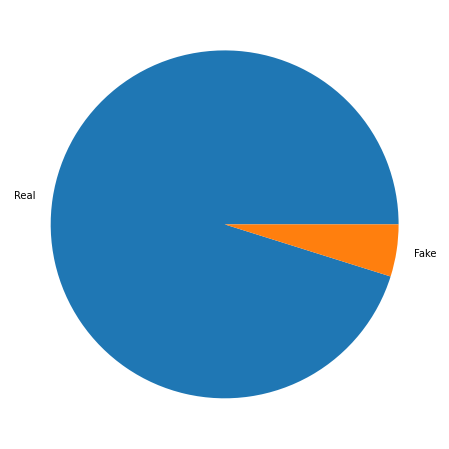

In [15]:
plt.pie([fake,real],labels=["Real","Fake"]);